In [56]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

# Self imports
from eclipses import *
from src import *
from plotting import *
from cpop import *
import nfft

In [11]:
from utils.set_dir_to_root import set_dir_to_root

# Getting the Curve
set_dir_to_root()
with open("data/all_systems.txt") as f:
    all_systems = f.read().split(",")
eclipses = get_eclipses(all_systems[21], "data/combined")  #kplr006545018.fits
#eclipses = eclipses.round({"delta":3})
eclipses.head()

,time,duration,delta
0,1.000000,0.020435,0.051087
2,1.051087,0.040869,0.051087
4,1.102173,0.020435,0.388258
6,1.490431,0.020435,0.490431
8,1.980862,0.020435,0.429127


58 eclipses dropped by outlier filter


C:\Users\User\Documents\GitHub\ThreeBody2\src\handle_double_eclipses.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eclipses["shifted"] = eclipses[col].shift(periods=-1)
C:\Users\User\Documents\GitHub\ThreeBody2\src\handle_double_eclipses.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eclipses["to_sum"] = close_to(eclipses[col], primary,
C:\Users\User\Documents\GitHub\ThreeBody2\src\handle_double_eclipses.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

<AxesSubplot:ylabel='Frequency'>

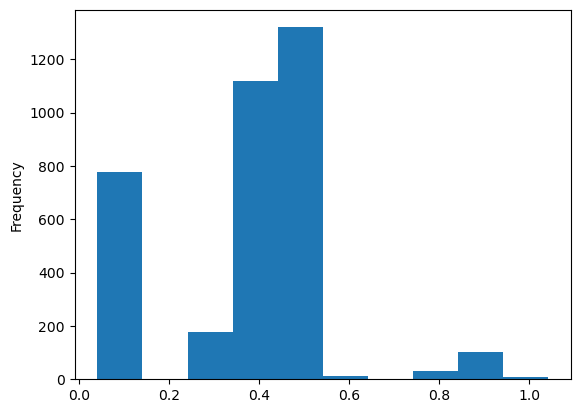

In [12]:
from src.handle_double_eclipses import remove_doubles
from src.noise_filtering import complete_filter

filtered = complete_filter(eclipses, "delta", return_diagnositics=False)
filtered['delta'].plot.hist()

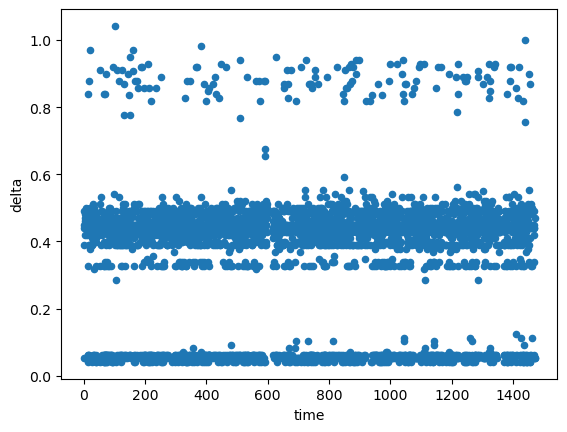

In [13]:
filtered.plot.scatter(y='delta', x='time')
plt.show()

In [14]:
period = getOC(filtered)
period

0.4532441901193981

In [15]:
period = period * round(filtered["delta"].median() / period, 0)
period  # this might break it, I hope not

0.4532441901193981

In [16]:
max(align_data(filtered["time"], period / 2) % period - period / 2)

0.22109988529988317

In [17]:
from src.noise_filtering import remove_outliers

filtered["residuals"] = align_data(filtered["time"], period / 2) % period - period / 2
filtered["residuals"]

0 eclipses dropped by outlier filter


0       0.000000
1       0.051087
2       0.102173
3       0.037187
4       0.050257
          ...   
3543   -0.088746
3544   -0.092429
3545   -0.126763
3546   -0.144345
3547   -0.093258
Name: residuals, Length: 3548, dtype: float64

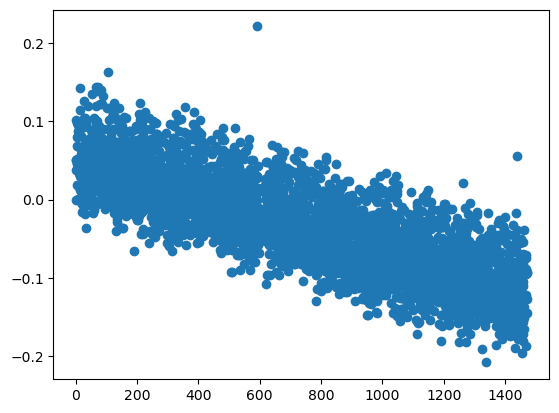

In [18]:
plt.scatter(x=filtered["time"], y=align_data(filtered["time"], period / 2) % period - period / 2)
plt.show()

In [19]:
N = 10000
k = - N // 2 + np.arange(N)
f_k = np.random.randn(N)

# non-equispaced fast Fourier transform
f = nfft.nfft(filtered["residuals"], f_k)

In [322]:
with open("data/all_systems.txt") as f:
    all_systems = f.read().split(",")

eclipses = get_eclipses(all_systems[7], "data/combined")
eclipses = get_eclipses("kplr006545018.fits", "data/combined")

In [359]:
filtered, period, diagnostics = getOC(eclipses, return_diagnostics=True)
diagnostics

(-3, 37, False, 0)

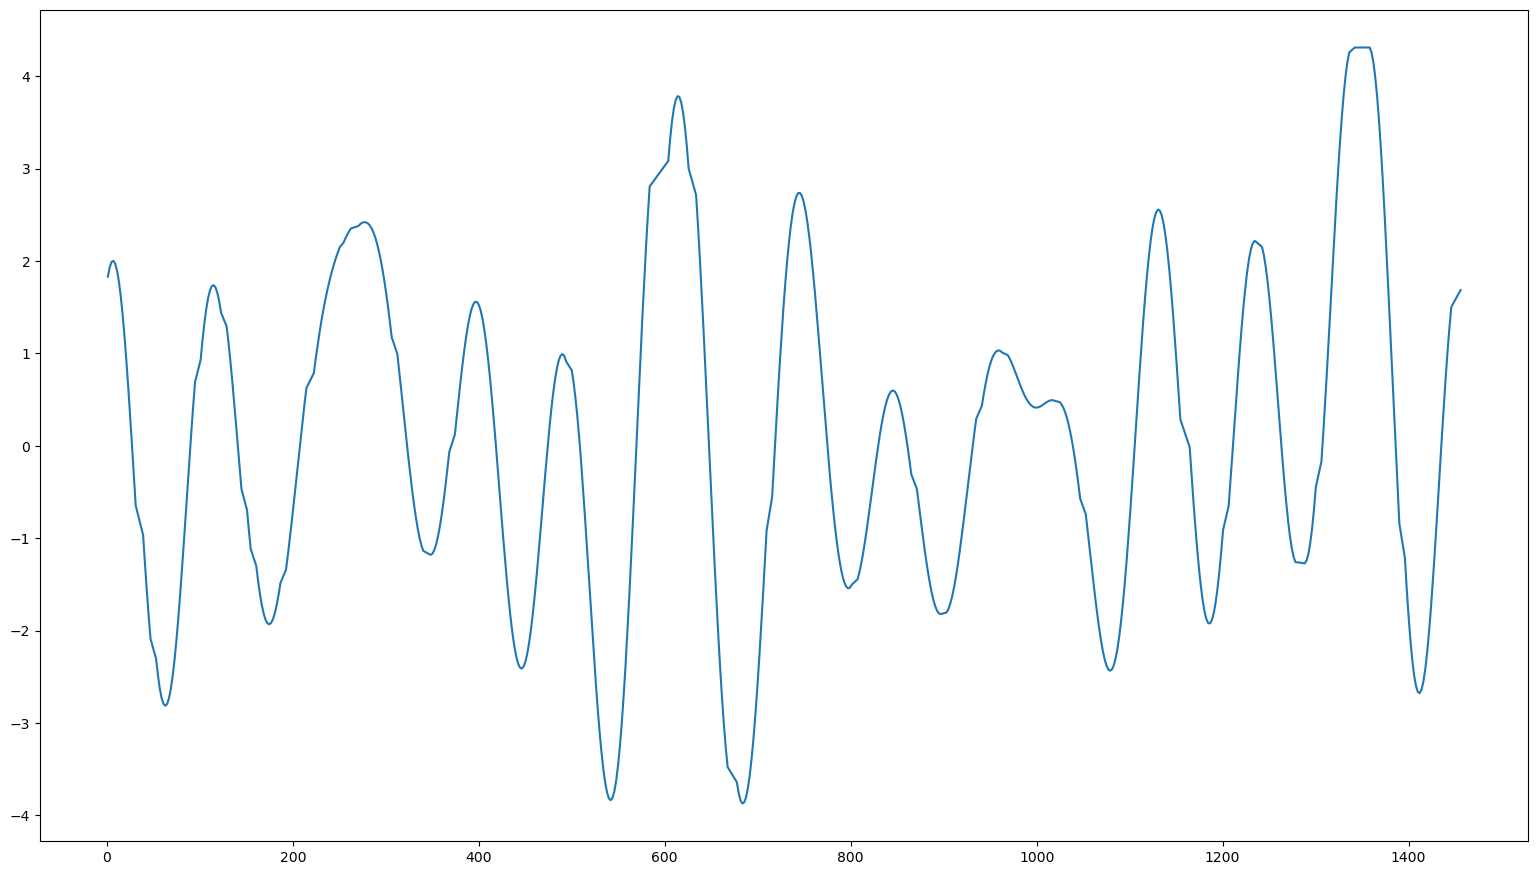

In [360]:
plt.figure(figsize=(19.2,10.8))
plt.plot(filtered["time"], filtered["culled_residuals"] * 1440)
plt.show()

In [324]:
filtered

,time,duration,delta,culled_delta,residuals,culled_residuals
0,1.000000,0.183911,2.002586,0.011134,0.000000,-0.002581
1,3.002586,0.183911,1.982151,-0.011997,0.006857,0.007062
2,4.984736,0.183911,2.002585,0.002504,-0.006721,-0.002848
3,6.987321,0.183911,2.002584,-0.001009,0.000136,0.001859
4,8.989905,0.183911,2.002583,0.002292,0.006991,0.001568
...,...,...,...,...,...,...
634,1439.911461,0.183909,2.002567,0.002733,-0.008720,-0.004683
635,1441.914029,0.183909,2.002569,0.006323,-0.001881,-0.000260
636,1443.916598,0.183909,1.982137,-0.012637,0.004960,0.007957
637,1445.898734,0.183910,2.002573,0.008232,-0.008632,-0.005607


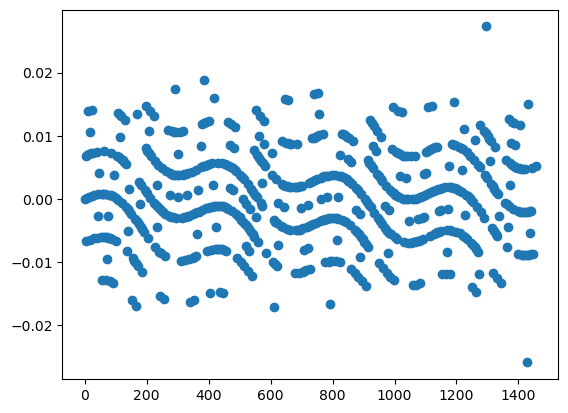

In [328]:
plt.scatter(x=filtered["time"], y=filtered["residuals"])
plt.show()

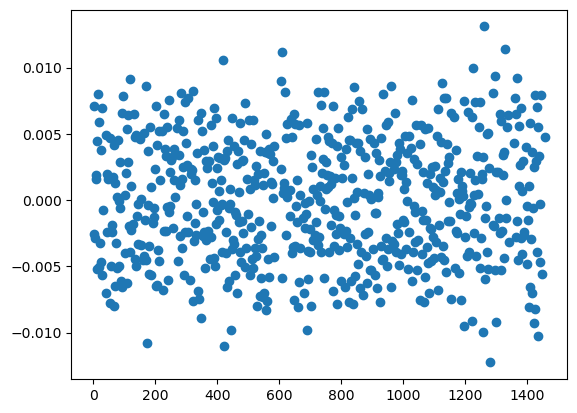

In [329]:
plt.scatter(x=filtered["time"], y=filtered["culled_residuals"])
plt.show()

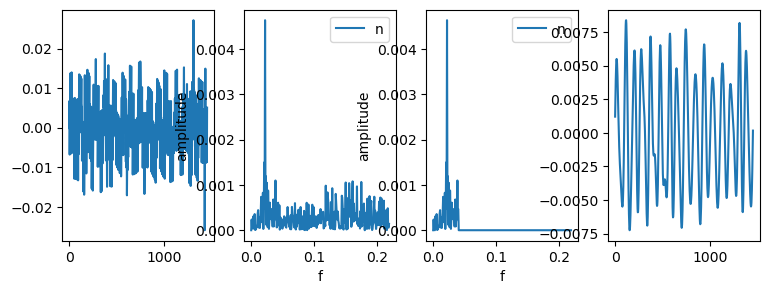

In [374]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import rfft, irfft, fftfreq, fft


y = filtered["residuals"].values - filtered["residuals"].mean()

oversampled_amount = int(math.pow(2, math.ceil(math.log(len(y),2))) - len(y))
if oversampled_amount / len(y) < 0.2:
    y = np.pad(y, (0, oversampled_amount), mode='constant')

# Number of samplepoints
N = len(y)
# sample spacing
T = filtered["time"].max() / N

x = np.linspace(0.0, (N-1)*T, N)
# x = np.arange(0.0, N*T, T)  # alternate way to define x

yf = rfft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
#fft end

f_signal = rfft(y)
W = fftfreq(y.size, d=T)

cut_f_signal = f_signal.copy()
cut_f_signal[((abs(W) > 0.0025) & (abs(W) < 0.003))] = 0  # filter out frequencies with periods of about a year
cut_f_signal[(abs(W) > 0.04) | (W < 0)] = 0
cut_signal = irfft(cut_f_signal)

# plot results
f, axarr = plt.subplots(1, 4, figsize=(9, 3))
axarr[0].plot(x, y)

axarr[1].plot(xf, 2.0/N * np.abs(yf[:N//2]))
axarr[1].legend(('numpy fft * dt'), loc='upper right')
axarr[1].set_xlabel("f")
axarr[1].set_ylabel("amplitude")

axarr[2].plot(xf, 2.0/N * np.abs(cut_f_signal[:N//2]))
axarr[2].legend(('numpy fft * dt'), loc='upper right')
axarr[2].set_xlabel("f")
axarr[2].set_ylabel("amplitude")


axarr[3].plot(x,cut_signal)

plt.show()

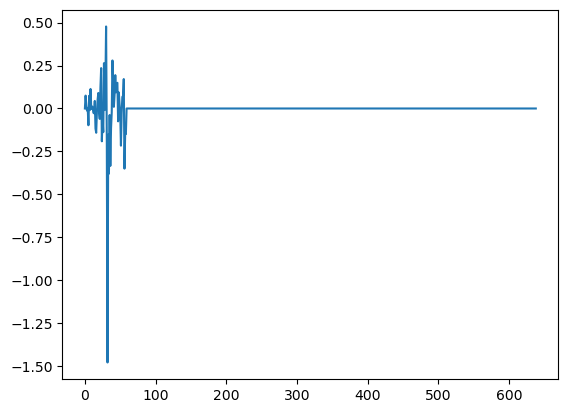

In [375]:
plt.plot(cut_f_signal)

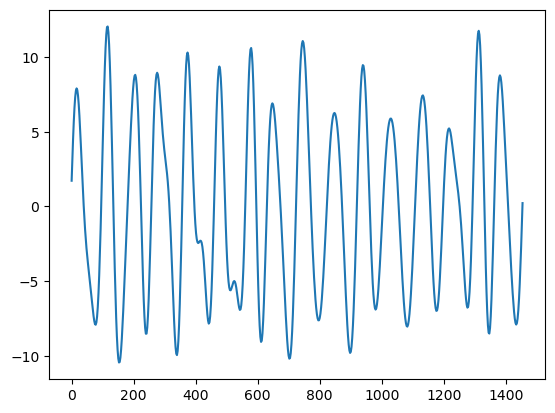

In [376]:
plt.plot(x, cut_signal * 1440)
plt.show()